In [51]:
import lal
import lalsimulation
import torch
import numpy as np
from astropy import units as u
from scipy.signal import butter, filtfilt

from ml4gw.constants import MSUN
from ml4gw.transforms.iirfilter import IIRFilter
from ml4gw.waveforms.conversion import (
    bilby_spins_to_lalsim,
    chirp_mass_and_mass_ratio_to_components,
)
import shutil
import matplotlib.pyplot as plt

mlp_params = {
    "figure.figsize": [9, 6],
    "axes.labelsize": 22,
    "axes.titlesize": 24,
    "axes.titlepad": 15,
    "figure.titlesize": 24,
    "axes.labelpad": 10,
    "font.size": 16,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "text.usetex": True if shutil.which("latex") else False,
    "font.family": "serif",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.top": True,
    "ytick.left": True,
    "ytick.right": True,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.minor.size": 2.5,
    "xtick.major.size": 5,
    "ytick.minor.size": 2.5,
    "ytick.major.size": 5,
    "axes.axisbelow": True,
    "figure.dpi": 200,
}
plt.rcParams.update(mlp_params)

In [52]:
low_cutoff = 100
high_cutoff = 20

order = 4
sample_rate = 1024
chirp_mass = torch.tensor([87.78623962402344])
mass_ratio = torch.tensor([0.12857399880886078])
mass_1, mass_2 = chirp_mass_and_mass_ratio_to_components(
    chirp_mass, mass_ratio
)
f_ref = 20.0
a_1 = torch.tensor([0.5])
a_2 = torch.tensor([0.8])
tilt_1 = torch.tensor([2.3])
tilt_2 = torch.tensor([0.5])
phi_12 = torch.tensor([1])
phi_jl = torch.tensor([1.23])
distance = torch.tensor([76.05146789550781])
theta_jn = torch.tensor([0.123333])
phase = torch.tensor([0.15683569014072418])
inclination, chi1x, chi1y, chi1z, chi2x, chi2y, chi2z = (
    torch.tensor([2.67919921875]),
    torch.tensor([-0.11896150559186935]),
    torch.tensor([-0.3594178557395935]),
    torch.tensor([0.6183903813362122]),
    torch.tensor([0.033942509442567825]),
    torch.tensor([0.35972997546195984]),
    torch.tensor([-0.7955602407455444]),
)

In [53]:
params = dict(
    m1=mass_1.item() * MSUN,
    m2=mass_2.item() * MSUN,
    S1x=chi1x.item(),
    S1y=chi1y.item(),
    S1z=chi1z.item(),
    S2x=chi2x.item(),
    S2y=chi2y.item(),
    S2z=chi2z.item(),
    distance=(distance.item() * u.Mpc).to("m").value,
    inclination=inclination.item(),
    phiRef=phase.item(),
    longAscNodes=0.0,
    eccentricity=0.0,
    meanPerAno=0.0,
    deltaF=1.0 / sample_rate,
    f_min=10.0,
    f_ref=f_ref,
    f_max=300,
    approximant=lalsimulation.IMRPhenomPv2,
    LALpars=lal.CreateDict(),
)
hp_lal, _ = lalsimulation.SimInspiralChooseFDWaveform(**params)
lal_freqs = np.array(
    [hp_lal.f0 + ii * hp_lal.deltaF for ii in range(len(hp_lal.data.data))]
)
lal_mask = (lal_freqs > params["f_min"]) & (lal_freqs < params["f_max"])


slice_length = int(0.1 * sample_rate)
lal_freqs = lal_freqs[lal_mask][slice_length:-slice_length]
hp_lal = hp_lal.data.data


b, a = butter(
    order,
    low_cutoff,
    btype="low",
    analog=False,
    output="ba",
    fs=sample_rate,
)
scipy_filtered_data_low = filtfilt(b, a, hp_lal.real)[lal_mask][
    slice_length:-slice_length
]
b, a = butter(
    order,
    high_cutoff,
    btype="high",
    analog=False,
    output="ba",
    fs=sample_rate,
)
scipy_filtered_data_high = filtfilt(b, a, hp_lal.real)[lal_mask][
    slice_length:-slice_length
]

butterworth_low = IIRFilter(
    order,
    low_cutoff,
    btype="low",
    analog=False,
    fs=sample_rate,
)
butterworth_high = IIRFilter(
    order,
    high_cutoff,
    btype="high",
    analog=False,
    fs=sample_rate,
)

torch_filtered_data_low = butterworth_low(torch.tensor(hp_lal.real))[lal_mask][
    slice_length:-slice_length
].numpy()
torch_filtered_data_high = butterworth_high(torch.tensor(hp_lal.real))[
    lal_mask
][slice_length:-slice_length].numpy()
hp_lal = hp_lal[lal_mask][slice_length:-slice_length]

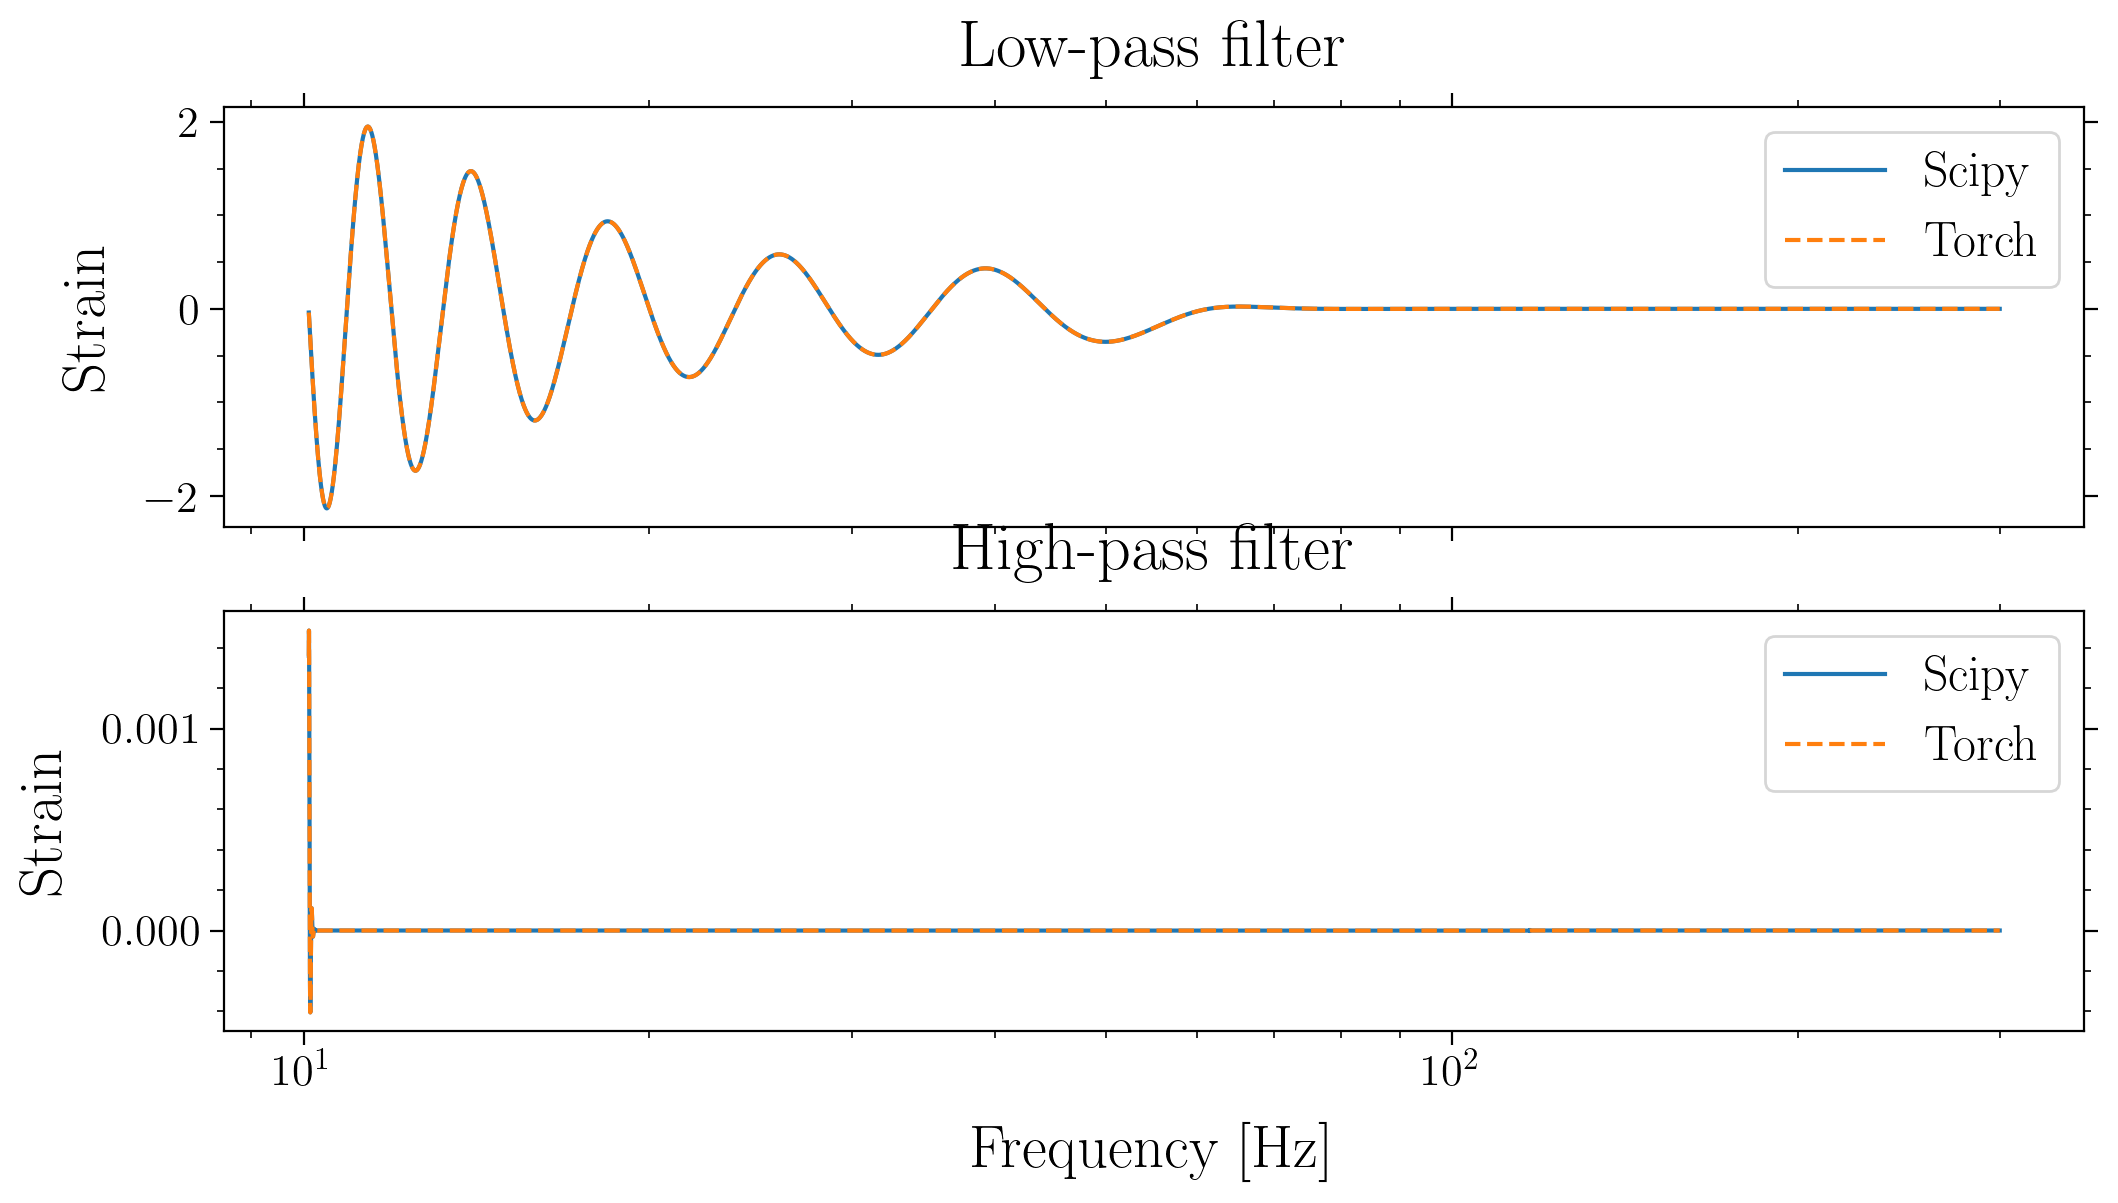

In [55]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
ax[0].plot(lal_freqs, 1e21 * scipy_filtered_data_low, label="Scipy")
ax[0].plot(lal_freqs, 1e21 * torch_filtered_data_low, "--", label="Torch")
ax[0].set_title("Low-pass filter")
ax[0].set_ylabel("Strain")
ax[0].legend()

ax[1].plot(lal_freqs, 1e21 * scipy_filtered_data_high, label="Scipy")
ax[1].plot(lal_freqs, 1e21 * torch_filtered_data_high, "--", label="Torch")
ax[1].set_title("High-pass filter")
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Strain")
ax[1].set_xscale("log")
ax[1].legend()

In [56]:
1e21 * (torch_filtered_data_low - scipy_filtered_data_low).max(), 1e21 * (
    torch_filtered_data_high - scipy_filtered_data_high
).max()

(1.3541694921472752e-14, 5.930987459052035e-13)